In [2]:
import os
import torch
from tqdm.auto import tqdm
import plotly.express as px
import pandas as pd
from copy import deepcopy

from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
from huggingface_hub import hf_hub_download, notebook_login, login
import numpy as np

from sae_lens.toolkit.pretrained_saes_directory import get_pretrained_saes_directory
from sae_lens import SAE, HookedSAETransformer

# Imports for displaying vis in Colab / notebook

torch.set_grad_enabled(False)

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

Device: mps


# Load Model and SAE

In [3]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
from huggingface_hub import hf_hub_download, notebook_login, login
import numpy as np
import torch

with open("./hf_token", "r") as f:
    token = f.read().strip()
    login(token, add_to_git_credential=True)

Token is valid (permission: fineGrained).
Your token has been saved in your configured git credential helpers (osxkeychain).
Your token has been saved to /Users/trangnguyen/.cache/huggingface/token
Login successful


In [4]:
model = HookedSAETransformer.from_pretrained("google/gemma-2-2b", device = device, center_unembed=False, cache_dir = "../pretrained_models")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-2-2b into HookedTransformer


In [5]:
width = ['16k', '32k']   #['16k', '1m', '262k', '32k', '524k', '65k']
layer = 12
sae_list = []

for w in width:
    sae, cfg_dict, sparsity = SAE.from_pretrained(
        release = "gemma-scope-2b-pt-res-canonical", # <- Release name
        sae_id = f"layer_{layer}/width_{w}/canonical", # <- SAE id (not always a hook point!)
        device = device,
    )
    sae_list.append( (sae, cfg_dict, sparsity))
    break

In [6]:
sae.cfg

SAEConfig(architecture='jumprelu', d_in=2304, d_sae=16384, activation_fn_str='relu', apply_b_dec_to_input=False, finetuning_scaling_factor=False, context_size=1024, model_name='gemma-2-2b', hook_name='blocks.12.hook_resid_post', hook_layer=12, hook_head_index=None, prepend_bos=True, dataset_path='monology/pile-uncopyrighted', dataset_trust_remote_code=True, normalize_activations=None, dtype='float32', device='mps', sae_lens_training_version=None, activation_fn_kwargs={}, neuronpedia_id='gemma-2-2b/12-gemmascope-res-16k', model_from_pretrained_kwargs={})

## Define Success Metrics

In [3]:
from typing import Dict


TARGET_VOCAB : Dict[str, list[str]] = {
    "wedding": ["wedding",
    "weddings",
    "wed",
    "marry",
    "married",
    "marriage",
    "bride",
    "groom",
    "honeymoon",
    "brides",
    "bridesmaid",
]
}
    

In [12]:
from typing import List
from activation_additions.metrics import get_word_count_metric
import pandas as pd

def success_rollout(generated_text: List[str], target_vocab: List[str], 
                    method="word_count_binary",
                    return_average_only=False):
    if method.startswith("word_count"):
        metric_func = get_word_count_metric(target_vocab)
        word_count, total_tokens = metric_func(generated_text)
        result = pd.merge(word_count, total_tokens, left_index=True, right_index=True)
        if method == "word_count_binary":
            result["metric"] = result["count"] > 0
        else:
            result["metric"] = result["count"] / result["n_tokens"]

        if return_average_only:
            return result["metric"].mean()
        else:
            return result["metric"].mean(), result
        
    else:
        raise NotImplementedError(f"Method {method} not implemented")

In [15]:
success_rollout(generated_text=["hello wedding", "hello"], target_vocab=TARGET_VOCAB["wedding"], method="word_count_binary", return_average_only=True)

(   count  n_tokens  metric
 0      1         2    True
 1      0         1   False,
 0.5)

In [8]:
def success_rollout():
    """
    Proportion of rollouts that contains vocabulary from a certain target
    """

## Implement steering vector

### Get the steering vector

In [9]:
# Source: https://colab.research.google.com/drive/1ubDl3dEY7aj3C2iEZOSczRWahAIgiFZJ?usp=sharing#scrollTo=0526bb02
from activation_additions.prompt_utils import get_x_vector, ActivationAddition
from functools import partial
from typing import Callable


default_kwargs = {
    "temperature": 1.0,
    "top_p": 0.3,
    "freq_penalty": 1.0,
    "num_comparisons": 3,
    "tokens_to_generate": 50,
    "seed": 0, # For reproducibility
}

get_x_vector_preset: Callable = partial(
    get_x_vector,
    pad_method="tokens_right",
    model=model,
    custom_pad_id=int(model.to_single_token(" ")),
)

In [10]:
from typing import List
from activation_additions.completion_utils import print_n_comparisons



summand: List[ActivationAddition] = [
    *get_x_vector_preset(
        prompt1="I talk about weddings constantly",
        prompt2="I do not talk about weddings constantly",
        coeff=4,
        act_name=20,
    )
]
FRIEND_PROMPT = (
    "I went up to my friend and said"
)
print_n_comparisons(model=model,
    prompt=FRIEND_PROMPT,
    activation_additions=summand,
    result_filepath="./results/gemma_wedding_steering_orig.csv",
    **default_kwargs,
)

+--------------------------------------------------------------+--------------------------------------------------------------+
|                    Unsteered completions                     |                     Steered completions                      |
+--------------------------------------------------------------+--------------------------------------------------------------+
|      I went up to my friend and said, "Hey, you want to      |      I went up to my friend and said, “Hey, you want to      |
|                       go see a movie?"                       |                       go see a movie?”                       |
|                                                              |                                                              |
|                       "Sure," he said.                       |                      “Sure,” she said.                       |
|                                                              |                                        

In [16]:
summand[0].to_dict()

AttributeError: 'ActivationAddition' object has no attribute 'to_dict'

### Running generation with steering

In [ ]:
def steering_hook(resid_pre, hook, steering_on=True, coeff=1.0, steering_vector=None):
    if resid_pre.shape[1] == 1:
        return

    position = sae_out.shape[1]
    if steering_on:
      # using our steering vector and applying the coefficient
      resid_pre[:, :position - 1, :] += coeff * steering_vector


def hooked_generate(prompt_batch, fwd_hooks=[], seed=None, **kwargs):
    if seed is not None:
        torch.manual_seed(seed)

    with model.hooks(fwd_hooks=fwd_hooks):
        tokenized = model.to_tokens(prompt_batch)
        result = model.generate(
            stop_at_eos=False,  # avoids a bug on MPS
            input=tokenized,
            max_new_tokens=50,
            do_sample=True,
            **kwargs)
    return result

def run_generate(example_prompt):
  model.reset_hooks()
  editing_hooks = [(f"blocks.{layer}.hook_resid_post", steering_hook)]
  res = hooked_generate([example_prompt] * 3, editing_hooks, seed=None, **sampling_kwargs)

  # Print results, removing the ugly beginning of sequence token
  res_str = model.to_string(res[:, 1:])
  print(("\n\n" + "-" * 80 + "\n\n").join(res_str))

## Reference

#### Sanity check

In [8]:
prompt = "Would you be able to travel through time using a wormhole?"
_, cache = model.run_with_cache_with_saes(prompt, saes=[sae_list[0][0]])

In [9]:
sae_relevant_info = [(k, v.shape) for k,v in cache.items() if "sae" in k]
sae_relevant_names = [k for (k, v) in sae_relevant_info]
print(sae_relevant_names)

['blocks.12.hook_resid_post.hook_sae_input', 'blocks.12.hook_resid_post.hook_sae_acts_pre', 'blocks.12.hook_resid_post.hook_sae_acts_post', 'blocks.12.hook_resid_post.hook_sae_recons', 'blocks.12.hook_resid_post.hook_sae_output']


In [10]:
sae_input = cache['blocks.12.hook_resid_post.hook_sae_input']
sae_output = cache['blocks.12.hook_resid_post.hook_sae_output']
sae_acts = cache['blocks.12.hook_resid_post.hook_sae_acts_post']
print('Recon error:', np.round((((sae_output[:,1:] - sae_input[:,1:])**2).mean()/sae_input[:,1:].var()).item(), 4))
print('L0', (sae_acts > 0).sum(-1))

Recon error: 0.0615
L0 tensor([[5015,   15,   52,   45,   79,   55,   70,   85,  113,  103,   79,  135,
          134,   72]], device='mps:0')


In [11]:
px.line(
    cache['blocks.12.hook_resid_post.hook_sae_acts_post'][0, -1, :].cpu().numpy(),
    title="Feature activations at the final token position",
    labels={"index": "Feature", "value": "Activation"},
).show()

### Identifying similar SAE features

In [8]:
# from IPython.display import IFrame
# html_template = "https://neuronpedia.org/{}/{}/{}?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300"

# def get_dashboard_html(sae_release = "gemma-2-2b", sae_id="12-gemmascope-res-16k", feature_idx=0):
#     return html_template.format(sae_release, sae_id, feature_idx)


In [4]:
# set thresholds = 0
print(sae_list[0][0].threshold.data.mean())
print(sae_list[1][0].threshold.data.mean())

tensor(3.1322, device='cuda:0')
tensor(3.1396, device='cuda:0')


In [4]:
cos_sims = (sae_list[0][0].W_dec/(1e-8 + sae_list[0][0].W_dec.norm(dim=-1, keepdim=True)) 
            @ (sae_list[1][0].W_dec/(1e-8 + sae_list[1][0].W_dec.norm(dim=-1, keepdim=True))).T).cpu()

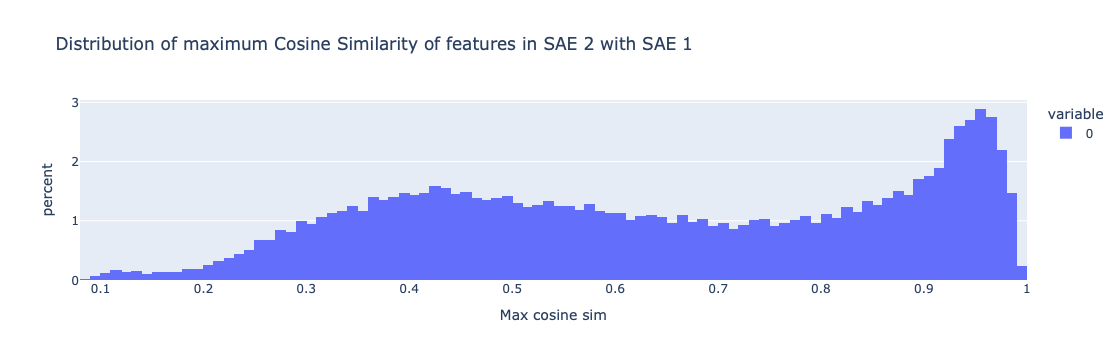

In [17]:
px.histogram(cos_sims.cuda().max(dim=0).values.cpu(), 
             histnorm='percent',
            labels={'value': 'Max cosine sim', 'percent': 'Frequency (as %)' },
           title='Distribution of maximum Cosine Similarity of features in SAE 2 with SAE 1 ')


In [4]:
from datasets import load_dataset
from transformer_lens.utils import tokenize_and_concatenate
from torch.utils.data import DataLoader, Subset


dataset = load_dataset(
    path = "NeelNanda/pile-10k",
    split="train",
    streaming=False,
)

token_dataset = tokenize_and_concatenate(
    dataset= dataset,# type: ignore
    tokenizer = model.tokenizer, # type: ignore
    streaming=True,
    max_length=sae_list[0][0].cfg.context_size,
    add_bos_token=sae_list[0][0].cfg.prepend_bos,
)

dataloader = DataLoader( Subset(token_dataset, range(1000)), batch_size=16, shuffle=False)


In [5]:
## find reconstruction error and sparsity

def recon_err_and_sparsity(model, sae, dataloader):
    recon_err = []
    l_0 = []
    mse = []
    sae_relevant_names = ['blocks.12.hook_resid_post.hook_sae_input',
                         'blocks.12.hook_resid_post.hook_sae_output',
                         'blocks.12.hook_resid_post.hook_sae_acts_post']
    for tokens in (pbar := tqdm(dataloader)):
        tokens = tokens['tokens']
        _, cache = model.run_with_cache_with_saes(tokens, saes=[sae], names_filter = sae_relevant_names, 
                                                  stop_at_layer = sae.cfg.hook_layer + 1,)

        sae_input = cache['blocks.12.hook_resid_post.hook_sae_input'][tokens != 2]
        sae_output = cache['blocks.12.hook_resid_post.hook_sae_output'][tokens != 2]
        sae_acts = cache['blocks.12.hook_resid_post.hook_sae_acts_post'][tokens != 2]

        mse.append( ((sae_output - sae_input)**2).mean().item() )
        recon_err.append((((sae_output - sae_input)**2).mean()/sae_input.var()).item())
        l_0.append((sae_acts > 0).sum(-1).float().mean().item())
        pbar.set_description_str(f'MSE: {np.round(np.mean(mse),4)}, Recon error: {np.round(np.mean(recon_err),4)} , L0: {np.round(np.mean(l_0),4)}')

    return np.round(np.mean(mse),4), np.round(np.mean(recon_err),4), np.round(np.mean(l_0),4)

In [9]:
recon_err_and_sparsity(model, sae_list[0][0], dataloader)

  0%|          | 0/63 [00:00<?, ?it/s]

(1.3823, 0.1543, 81.9456)

In [13]:
recon_err_and_sparsity(model, sae_list[1][0], dataloader)

  0%|          | 0/63 [00:00<?, ?it/s]

(1.6517, 0.1843, 1028.6847)

In [6]:
def combine_saes(sae, big_sae, num_vecs, sim_thresh=0.7):
    sae_vecs = sae.W_dec
    big_sae_vecs = big_sae.W_dec
    sae_vecs /= (1e-8 + sae_vecs.norm(dim=-1, keepdim=True))
    big_sae_vecs /= (1e-8 + big_sae_vecs.norm(dim=-1, keepdim=True))
    cos_sims = big_sae_vecs @ sae_vecs.T
    max_cos_sims = cos_sims.max(dim=-1).values
    max_new_vecs = (max_cos_sims < sim_thresh).int().sum().item()
    if num_vecs > max_new_vecs:
        print(f'Only {max_new_vecs} vectors allowed, setting num_vecs to {max_new_vecs}')
        num_vecs = max_new_vecs
    new_vec_inds = torch.argsort(max_cos_sims)[:num_vecs]
    print(torch.sort(max_cos_sims)[0][num_vecs])
    new_cfg = deepcopy(sae.cfg)
    new_cfg.d_sae += num_vecs
    new_sae = SAE(new_cfg)
    new_sae.threshold.data = torch.cat((sae.threshold.data, big_sae.threshold.data[new_vec_inds]), dim=0)
    new_sae.W_dec.data = torch.cat((sae.W_dec.data, big_sae.W_dec.data[new_vec_inds]), dim=0)
    new_sae.b_dec.data = sae.b_dec.data #+ big_sae.b_dec.data*num_vecs/len(max_cos_sims)
    new_sae.W_enc.data = torch.cat((sae.W_enc.data, big_sae.W_enc.data[:,new_vec_inds]), dim=1)
    new_sae.b_enc.data = torch.cat((sae.b_enc.data, big_sae.b_enc.data[new_vec_inds]), dim=0)
    return new_sae

In [31]:
for num_vecs in [10, 100, 1000]:
    new_sae = combine_saes(sae_list[0][0], sae_list[1][0], num_vecs, sim_thresh=0.7)
    print(recon_err_and_sparsity(model, new_sae, dataloader))

tensor(0.0855, device='cuda:0')


  0%|          | 0/63 [00:00<?, ?it/s]

KeyboardInterrupt: 